<a href="https://colab.research.google.com/github/tpeterz/happy-flix/blob/main/Reviews/VADERS_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This file contains a thorough analysis with:
- VADERS
- RandomForest

In [ ]:
# Importing
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)
import string
string.punctuation
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import TweetTokenizer

In [ ]:
%rm -rf sample_data/

In [ ]:
# Loading Datasets into Colab
movie_df = pd.read_csv('/combined_movies.csv');

In [ ]:
# Print the shape
print(movie_df.shape)

(6123, 16)


In [ ]:
# Drop unnecessary columns
movie_df.drop(columns=['Unnamed: 0', 'adult', 'backdrop_path','original_language', 'original_title',
                 'video', 'vote_average', 'vote_count'], inplace=True)

In [ ]:
import ast

# Genre ID to name mapping
genre_mapping = {
    28: 'Action', 12: 'Adventure', 16: 'Animation', 35: 'Comedy', 80: 'Crime',
    99: 'Documentary', 18: 'Drama', 10751: 'Family', 14: 'Fantasy', 36: 'History',
    27: 'Horror', 10402: 'Music', 9648: 'Mystery', 10749: 'Romance', 878: 'Science Fiction',
    10770: 'TV Movie', 53: 'Thriller', 10752: 'War', 37: 'Western'
}

# Create a column for each genre with a prefix
for genre_id, genre_name in genre_mapping.items():
    column_name = f"type_{genre_name}"
    movie_df[column_name] = movie_df['genre_ids'].apply(lambda ids: 1 if genre_id in ast.literal_eval(ids) else 0)

movie_df.head()

genre_ids       id  \
0                [878, 12]   693134   
1  [16, 28, 12, 35, 10751]  1011985   
2        [28, 878, 12, 14]   823464   
3                 [28, 53]   359410   
4                 [28, 14]   634492   

                                                                                                                                                                                                                                                                                                            overview  \
0  Follow the mythic journey of Paul Atreides as he unites with Chani and the Fremen while on a path of revenge against the conspirators who destroyed his family. Facing a choice between the love of his life and the fate of the known universe, Paul endeavors to prevent a terrible future only he can foresee.   
1                          Po is gearing up to become the spiritual leader of his Valley of Peace, but also needs someone to take his place as Dragon Warrior. As such, he will train a new kung fu practitioner for the spot and will encounter a villain called the Chameleon who conjures villains from the past.   
2                                                                                                                                 Following their explosive showdown, Godzilla and Kong must reunite against a colossal undiscovered threat hidden within our world, challenging their very existence – and our own.   
3                                                                                                                                                                               Ex-UFC fighter Dalton takes a job as a bouncer at a Florida Keys roadhouse, only to discover that this paradise is not all it seems.   
4                                                                                                                     Forced to confront revelations about her past, paramedic Cassandra Webb forges a relationship with three young women destined for powerful futures...if they can all survive a deadly present.   

   popularity                       poster_path release_date  \
0    4534.956  /1pdfLvkbY9ohJlCjQH2CZjjYVvJ.jpg   2024-02-27   
1    3214.314  /f7QBvIzoWSJw3jWPGnZBc5vwQ0l.jpg   2024-03-02   
2    2297.340  /tMefBSflR6PGQLv7WvFPpKLZkyk.jpg   2024-03-27   
3    1134.726  /bXi6IQiQDHD00JFio5ZSZOeRSBh.jpg   2024-03-08   
4     921.140  /rULWuutDcN5NvtiZi4FRPzRYWSh.jpg   2024-02-14   

                             title  \
0                   Dune: Part Two   
1                  Kung Fu Panda 4   
2  Godzilla x Kong: The New Empire   
3                       Road House   
4                       Madame Web   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [ ]:
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6123 entries, 0 to 6122
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   genre_ids             6123 non-null   object 
 1   id                    6123 non-null   int64  
 2   overview              6123 non-null   object 
 3   popularity            6123 non-null   float64
 4   poster_path           6119 non-null   object 
 5   release_date          6123 non-null   object 
 6   title                 6123 non-null   object 
 7   reviews               6123 non-null   object 
 8   type_Action           6123 non-null   int64  
 9   type_Adventure        6123 non-null   int64  
 10  type_Animation        6123 non-null   int64  
 11  type_Comedy           6123 non-null   int64  
 12  type_Crime            6123 non-null   int64  
 13  type_Documentary      6123 non-null   int64  
 14  type_Drama            6123 non-null   int64  
 15  type_Family          

In [ ]:
def clean_text(text):
    # Remove a specific phrase with changing URL
    text = re.sub(r'FULL SPOILER-FREE REVIEW @ https?://\S+', '', text)
    # Remove any remaining URLs
    text = re.sub(r'https?://\S+', '', text)
    # Remove emojis by filtering out characters that are not in the expected ranges
    text = re.sub(r'[^\w\s,]', '', text)
    return text

movie_df['clean_reviews'] = movie_df['reviews'].apply(clean_text)

In [ ]:
!pip install nltk
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
movie_df['sentiment_scores'] = movie_df['clean_reviews'].apply(lambda review: sia.polarity_scores(review))
movie_df['compound_score'] = movie_df['sentiment_scores'].apply(lambda d: d['compound'])

In [ ]:
# Categorize the sentiment based on the compound score
def categorize_score(score):
    if score > 0.05:
        return 'positive'
    elif score < -0.05:
        return 'negative'
    else:
        return 'neutral'

movie_df['sentiment'] = movie_df['compound_score'].apply(categorize_score)

In [ ]:
# Split the dataset into training and testing sets (optional, based on your needs)
X_train, X_test, y_train, y_test = train_test_split(movie_df['clean_reviews'], movie_df['sentiment'], test_size=0.25, random_state=42)

In [ ]:
# Output some samples to verify
print("Training data samples:")
print(X_train)
print(y_train)

print("\nTesting data samples:")
print(X_test)
print(y_test)

Training data samples:
1669                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      _Marcel the Shell with Shoes On_ is the type of film that reminds you what its like to be a decent human being through the perspective of a little talking shell that walks on the walls of a normal sized house by stepping in a puddle of honey The film is laugh out loud funny, sad in a gut punchi

# Plotting the above distribution of sentiments detected

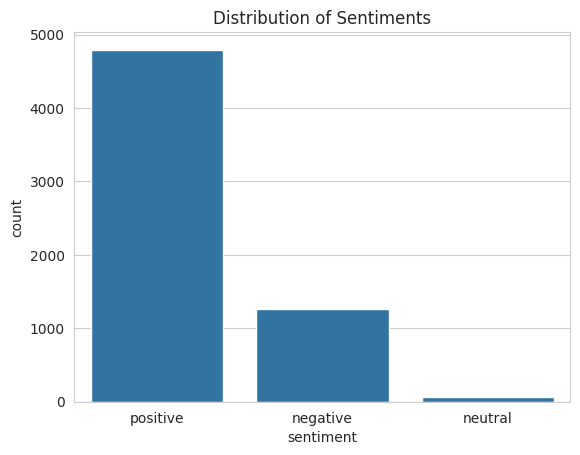

In [ ]:
import matplotlib.pyplot as plt

# Plot the distribution of sentiments
sns.countplot(x='sentiment', data=movie_df)
plt.title('Distribution of Sentiments')
plt.show()

In [ ]:
print(movie_df.columns)

Index(['genre_ids', 'id', 'overview', 'popularity', 'poster_path',
       'release_date', 'title', 'reviews', 'type_Action', 'type_Adventure',
       'type_Animation', 'type_Comedy', 'type_Crime', 'type_Documentary',
       'type_Drama', 'type_Family', 'type_Fantasy', 'type_History',
       'type_Horror', 'type_Music', 'type_Mystery', 'type_Romance',
       'type_Science Fiction', 'type_TV Movie', 'type_Thriller', 'type_War',
       'type_Western', 'clean_reviews', 'sentiment_scores', 'compound_score',
       'sentiment'],
      dtype='object')


In [ ]:
# Group by 'sentiment' and genre columns, and count the number of reviews in each group
# Then, reset the index to make 'sentiment' a column again
genre_sentiment_counts = movie_df.groupby(['sentiment', 'type_Action', 'type_Adventure', 'type_Animation', 'type_Comedy', 'type_Crime',
                                                                 'type_Documentary', 'type_Drama', 'type_Family', 'type_Fantasy', 'type_History',
                                                                 'type_Horror', 'type_Music', 'type_Mystery', 'type_Romance', 'type_Science Fiction',
                                                                 'type_TV Movie', 'type_Thriller', 'type_War', 'type_Western']).size().unstack().reset_index()

In [ ]:
# Group by genre and sentiment, and count the number of reviews in each group
genre_sentiment_counts = movie_df.groupby(['sentiment', 'type_Action', 'type_Adventure', 'type_Animation', 'type_Comedy', 'type_Crime',
                                                                 'type_Documentary', 'type_Drama', 'type_Family', 'type_Fantasy', 'type_History',
                                                                 'type_Horror', 'type_Music', 'type_Mystery', 'type_Romance', 'type_Science Fiction',
                                                                 'type_TV Movie', 'type_Thriller', 'type_War', 'type_Western']).size().unstack()

# Random Forest Classifier

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Assuming 'clean_reviews' is your feature column and 'sentiment' is your target column
X = movie_df['clean_reviews']
y = movie_df['sentiment']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorize the text data
vectorizer = TfidfVectorizer()
X_train_transformed = vectorizer.fit_transform(X_train)
X_test_transformed = vectorizer.transform(X_test)

# Train a model (example: RandomForestClassifier)
model = RandomForestClassifier()
model.fit(X_train_transformed, y_train)

# Make predictions
y_pred = model.predict(X_test_transformed)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.8016326530612244
              precision    recall  f1-score   support

    negative       0.87      0.08      0.15       246
     neutral       0.00      0.00      0.00        14
    positive       0.80      1.00      0.89       965

    accuracy                           0.80      1225
   macro avg       0.56      0.36      0.35      1225
weighted avg       0.81      0.80      0.73      1225

